# Example 2: the Poisson problem

This problem is related to this work in progress: https://github.com/mdh959/T3-PINNS .

In this notebook we will solve the "partial" differential equation $-u''(x)=f(x)$ on the circle, where $f$ is a given function and $u$ is the unknown function we want to solve for.
"Partial" is in quotation marks, because the circle is one-dimensional, so this can be viewed as an ordinary differential equation.
This equation is called the *Poisson problem*.

We define our circle $S^1$ to be the interval $[0, 2pi]$ with endpoints identified, i.e. $0 \sim 2pi$ and $S^1=[0, 2pi]/\sim$.
For practice, we set $f(x)=sin(x)$, though we could have chosen something else.
Notice that $sin(x)$ is a well-defined function on $S^1$, because $sin(0)=sin(2pi)$.
Not every function would work here, for example $f(x)=x^2$ does not work.

The exact solution of this equation has an easy formula.
It is: $u(x)=sin(x)$.
So, we wouldn't really need to use a neural network to approximately solve this equation, but we do this anyway as a practice for more complicated equations.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [ ]:
class PINN:
    def __init__(self):
        # The neural network is defined here
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,), dtype=tf.float64),  # Input layer
            tf.keras.layers.Dense(units=16, activation='tanh', dtype=tf.float64),
            tf.keras.layers.Dense(units=1, dtype=tf.float64)  # Output layer
        ])

    def partial_derivative(self, tape, u, x, dim):
        # Computes the partial derivative in direction dim.
        # For ODEs, one always has dim=0.
        du_dx = tape.gradient(u, x)
        return du_dx[:, dim]

    def pde_error(self, x, tape):
        x = tf.expand_dims(x, axis=0)
        tape.watch(x)

        u = self.model(x)
        target = tf.math.sin(x)

        du_dx = self.partial_derivative(tape, u, x, 0)
        ddu_ddx = self.partial_derivative(tape, du_dx, x, 0)

        errors = target + ddu_ddx

        L2error = tf.reduce_sum(tf.square(errors))
        return L2error

    def loss(self, x_collocation, tape):
        errors = tf.vectorized_map(lambda x: self.pde_error(x, tape), x_collocation)
        loss = tf.reduce_mean(errors)

        return loss


    @tf.function
    def compute_loss_and_gradients(self, x_collocation):
        with tf.GradientTape(persistent=True) as tape:
            normalised_loss = self.loss(x_collocation, tape)
        grads = tape.gradient(normalised_loss, self.model.trainable_variables)
        return normalised_loss, grads

    def train(self, x_collocation, epochs, learning_rate):
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        for epoch in range(epochs):
            normalised_loss, grads = self.compute_loss_and_gradients(x_collocation)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Loss = {normalised_loss.numpy()}")

    def evaluate(self, inputs):
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float64)
        outputs = self.model(inputs)
        return outputs


In [ ]:
# Sample points in the interval [0,2pi]
num_samples = 100
x_collocation = np.random.uniform(low=0, high=2 * np.pi, size=(num_samples, 1))
x_collocation = tf.convert_to_tensor(x_collocation, dtype=tf.float64)

pinn = PINN()
pinn.train(x_collocation, epochs=50, learning_rate=0.01)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['sequential_13/dense_34/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 0: Loss = 0.6918119116948582
Epoch 5: Loss = 0.559684065750424
Epoch 10: Loss = 0.46645324697671353
Epoch 15: Loss = 0.3992231180060159
Epoch 20: Loss = 0.34622008820889727
Epoch 25: Loss = 0.3009686378222603
Epoch 30: Loss = 0.2614378532452993
Epoch 35: Loss = 0.22907197432313123
Epoch 40: Loss = 0.20438626529171983
Epoch 45: Loss = 0.18292614618119848


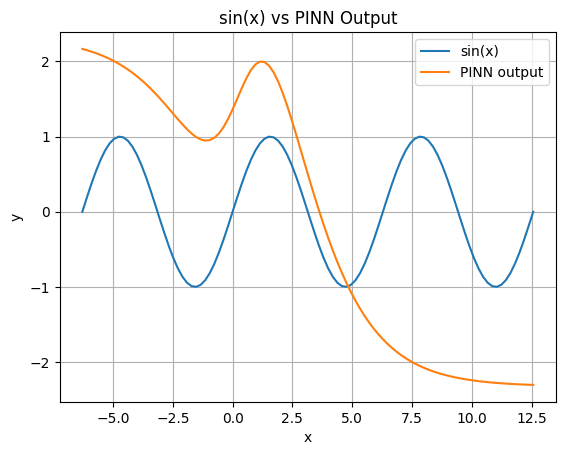

In [ ]:
import matplotlib.pyplot as plt

# Generate points for plotting
x_plot = np.linspace(-2*np.pi, 4 * np.pi, 100)
x_plot = tf.convert_to_tensor(x_plot.reshape(-1, 1), dtype=tf.float64)
y_true = np.sin(x_plot)

# Get PINN predictions
y_pred = pinn.evaluate(x_plot)
y_pred = y_pred.numpy()

# Plot sin(x) vs PINN output
plt.plot(x_plot, y_true, label='sin(x)')
plt.plot(x_plot, y_pred, label='PINN output')
plt.xlabel('x')
plt.ylabel('y')
plt.title('sin(x) vs PINN Output')
plt.legend()
plt.grid(True)
plt.show()


Questions:

1.   The performance of the neural network above is very bad. Change the loss function to add a term $\text{average}(u(0)^2, u(2pi)^2)$. This encourages the network to learn $u(0)=0$ and $u(2pi)=0$. Copy all code achieving this and plotting sin(x) versus the learned function (as above) in a single cell below this question.


2.   The performance is still not great. Without implementing the change from point 3 below, change the network architecture and training loop to improve accuracy. Create a text cell in which you explain the changes you made. Copy all code achieving this and plotting sin(x) versus the learned function (as above) in a single cell below this question.

3.   The learned function $u$ is not well-defined on the circle. The plot above shows that: while $\sin(x)$ is $2 \pi$-periodic, the function $u$ is not. Make the neural network $2 \pi$-periodic, so that the learned function is guaranteed to be periodic. One way to do this is to map an input `x` to `[sin(x), cos(x)]` in the first layer of your neural network, and then have the rest of the neural network follow normally. The result is then guaranteed to be $2\pi$-periodic. Use the original version of the network I supplied (with one hidden layer with 16 neurons) and add this `[sin(x), cos(x)]` layer. Copy all code achieving this and plotting sin(x) versus the learned function (as above) in a single cell below this question.

4.    We want to use this neural network in a *numerically verified proof*, proving that there exists an exact solution near your approximate, computer-generated solution.
To make computations easier, take your neural network to be:

```Input x -> [cos(x), sin(x)] -> w11*cos(x)+w12*sin(x)+b1 -> tanh(w11*cos(x)+w12*sin(x)+b1) -> w2*tanh(w11*cos(x)+w12*sin(x)+b1)+b2```

I.e. a single hidden layer with one neuron. Train a network with this architecture.

For this we need to compute an upper bound for the function $\text{error}(x)=u''(x)+sin(x)$ on $[0,2pi]$. This is done as follows:
(A) Compute an upper bound for $|(d/dx)error(x)|$. To do this, use $|(d/dx)(u''(x)+\sin(x))| \leq |u'''(x)|+|\cos(x)|$. You have $u(x)=w2*tanh(w11*cos(x)+w12*sin(x)+b1)+b2$. Compute a formula for $u'''$ (I computed one, below). Print the weights w11, w12, b1, w2, b2 of your trained network and plug this into your expression of $|u'''|$ to compute an upper bound for $|(d/dx)error(x)|$.
(B) Choose 1 million equally spaced points on $[0,2pi]$ and compute $\text{error}(x)$ at these points.
(C) Assume the upper bound from step A obtained by you is $M$ and the maximum of $error(x)$ at the 1 million points from step B is $\epsilon$. Explain why then $\text{error}(x)$ is bounded on all of $[0,2pi]$ by $\epsilon+M \cdot \pi/1000000$.

Create a code cell for your solution to (A) in which you train the network and print its weights. Then write a comment in this code cell stating which bound you get for $u'''$.

Create a code cell for your solution to (B).

Create a text cell for your solution to (C). You need not calculate anything here, just give an explanation.

Formula for $u'''(x)$:

```
-2 w2 Sech[
   b1 + w12 Cos[x] + w11 Sin[x]]^4 (w11 Cos[x] - w12 Sin[x])^3 +
 w2 Sech[b1 + w12 Cos[x] + w11 Sin[x]]^2 (-w11 Cos[x] + w12 Sin[x]) -
 6 w2 Sech[
   b1 + w12 Cos[x] + w11 Sin[x]]^2 (-w12 Cos[x] -
    w11 Sin[x]) (w11 Cos[x] - w12 Sin[x]) Tanh[
   b1 + w12 Cos[x] + w11 Sin[x]] +
 4 w2 Sech[
   b1 + w12 Cos[x] + w11 Sin[x]]^2 (w11 Cos[x] - w12 Sin[x])^3 Tanh[
   b1 + w12 Cos[x] + w11 Sin[x]]^2
where |Sech(y)| <= 1 and |Tanh(y)| <= 1 for all y.
```

5*.    So far we considered the operator $-u''$. This is the one-dimensional Laplace operator for the Euclidean metric. Really we are interested in the product space $T^3=S^1 \times S^1 \times S^1$ and arbitrary metrics $g$ on $T^3$, which can be viewed as a function $g:T^3 \rightarrow \mathbb{R}^{3 \times 3}$.
Its Laplace operator is defined as:
$$\Delta u =
-
\sum_{i,j=1}^3
\frac{1}{\sqrt{g}} \partial_i \sqrt{g} \cdot g^{ij} \partial_j u,$$
where $g^{ij}$ denotes the $(i,j)$-entry of the matrix $g^{-1}$.
Create a Physics-informed neural network to solve $\Delta u=\sin(x) \sin(y) \sin(z)$ where $x,y,z \in [0,2\pi]$ are coordinates on $T^3$.

The last complication is that we are interested in the Lapacian on vector fields, not on function.
There is no time during this class, but you can look up the definition of Laplacian on vector fields (or more precisely: the Laplacian on 1-forms) and think about how to implement this.